# Bayes Theorem for Predicting the Probability of an Email Being Spam

S = Spam
w = Word

$P(Spam|w_{1}, w_{2},..., w_{n}) \propto P(Spam) \cdot \prod_{i=1}^{n}P(w_{i}|Spam)$

The probability that an email consisting of the words $w_{1}, w_{2},... w_{n}$ is proportional to the probability that any given email is spam multiplied by the product of each word's probability to appear in a spam email.



In [1]:
from matplotlib import pyplot as plt

import pandas as pd
import math
import time
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

pd.options.mode.chained_assignment = None  # default='warn'

PREDICTION = 'Prediction'
CLASSIFICATION = 'Classiciation'

## Functions

In [2]:
def count_vocab(emails):
    total_words = 0
    
    for index, row in emails.iterrows():
        total_words += sum(row.values[1:-2])
            
    return total_words

In [3]:
def calculate_word_spamicity(w_spam_count, vocab, spam_vocab):
    alpha = 1
    
    spamicity = (w_spam_count + alpha) / (spam_vocab + alpha * vocab)
    return spamicity

In [4]:
def build_word_spamicity_dict(spam_emails, vocab, spam_vocab):
    spam_word_appearances = {}
    
    for (column_name, column_data) in spam_emails.iteritems():
        if column_name != 'Email No.' and column_name != PREDICTION and column_name != CLASSIFICATION:
            spam_word_appearances[column_name] = sum(column_data.values)
            
    for word in spam_word_appearances:
        spam_word_appearances[word] = calculate_word_spamicity(spam_word_appearances[word], vocab, spam_vocab)
            
    return spam_word_appearances

In [5]:
def calculate_email(email, word_spamicities, word_hamicities, spam_proportion, ham_proportion, testing_data):
    email_spamicity = math.log(spam_proportion)
    email_hamicity = math.log(ham_proportion)
    
    for column in testing_data.columns[1:-2]:
        if email[column] > 0:
            email_spamicity += math.log(word_spamicities[column])*email[column]
            email_hamicity += math.log(word_hamicities[column])*email[column]
            
    return 1 if email_spamicity >= email_hamicity else 0
            

In [6]:
def calculate_accuracy(testing_emails):
    number_correct = 0
    for index, email in testing_emails.iterrows():
        if email[PREDICTION] == email[CLASSIFICATION]:
            number_correct += 1
        
    return number_correct / testing_emails.shape[0] * 100

In [14]:
def run_model(data, include_stop_words=True):
    end = 0
    begin = 0
    
    score_total = 0
    time_total = 0
    
    if not include_stop_words:
        # Take out all stopwords
        for col in df.columns:
            if col in stop_words:
                data.drop(col, axis=1, inplace=True)
                
    results = {'partition': [], 'accuracy': [], 'time_elapsed': []}

    total_num_emails = data.shape[0]

    # Subtract 2 for "Email No." and "Prediction" columns
    total_vocab = len(data.columns) - 2

    partition_size = total_num_emails//5

    for i in range(1,6):
        start_time = time.time()
        end += partition_size
        
        results['partition'].append(i)

        if i == 1:
            testing_data = data.iloc[begin:end].copy()
            training_data = df.iloc[end:]
        elif i == 5:
            testing_data = data.iloc[begin:].copy()
            training_data = df.iloc[:begin]
        else:
            testing_data = data.iloc[begin:end].copy()
            training_data_sections = []
            training_data_sections.append(data.iloc[:begin])
            training_data_sections.append(data.iloc[end:])
            training_data = pd.concat(training_data_sections)
            
        # This is where the model's prediction will be stored
        testing_data[CLASSIFICATION] = ""

        begin += partition_size

        spam_proportion = training_data['Prediction'].value_counts()[1] / training_data.shape[0]
        ham_proportion = training_data['Prediction'].value_counts()[0] / training_data.shape[0]

        spam_training_emails = training_data.loc[training_data[PREDICTION] == 1]
        total_spam_words = count_vocab(spam_training_emails)

        ham_training_emails = training_data.loc[training_data[PREDICTION] == 0]
        total_ham_words = count_vocab(ham_training_emails)

        word_spamicities = build_word_spamicity_dict(spam_training_emails, total_vocab, total_spam_words)
        word_hamicities = build_word_spamicity_dict(ham_training_emails, total_vocab, total_ham_words)

        i = 0
        for index, email in testing_data.iterrows():
            testing_data[CLASSIFICATION].loc[testing_data.index[i]] = calculate_email(email, word_spamicities, word_hamicities, spam_proportion, ham_proportion, testing_data)
            i += 1

        score = calculate_accuracy(testing_data)
        results['accuracy'].append(score)
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        results['time_elapsed'].append(elapsed_time)
        
        score_total += score
        time_total += elapsed_time

    print(f'\nAverage Accuracy: {score_total/5}%')
    print(f'Average Time: {time_total/5}%')
    return results

# Model

## Step 1: Partition the data into training and test segments

20% of the data for testing, and the remaining 80% is training (i.e. the 80% training data will confirm whether the 20% testing data labels are correct).

In [15]:
df = pd.read_csv('emails.csv')

print('STOP WORDS INCLUDED\n')
with_stopwords_results = run_model(df, True)

STOP WORDS INCLUDED


Average Accuracy: 94.06551757615587%
Average Time: 11.458710432052612%


In [16]:
with_stopwords_results_table = pd.DataFrame(data = with_stopwords_results)
with_stopwords_results_table['with_stopwords'] = [True, True, True, True, True]
with_stopwords_results_table

,partition,accuracy,time_elapsed,with_stopwords
0,1,93.907157,11.441971,True
1,2,96.518375,11.488254,True
2,3,95.454545,11.354519,True
3,4,93.810445,11.587887,True
4,5,90.637066,11.420921,True


In [17]:
print('STOP WORDS NOT INCLUDED\n')
without_stopwords_results = run_model(df, False)


STOP WORDS NOT INCLUDED


Average Accuracy: 93.75611450079536%
Average Time: 10.690002632141113%


In [18]:
without_stopwords_results_table = pd.DataFrame(data = without_stopwords_results)
without_stopwords_results_table['with_stopwords'] = [False, False, False, False, False]
without_stopwords_results_table

,partition,accuracy,time_elapsed,with_stopwords
0,1,93.230174,10.639996,False
1,2,96.518375,10.766410,False
2,3,95.164410,10.672767,False
3,4,93.423598,10.658188,False
4,5,90.444015,10.712652,False


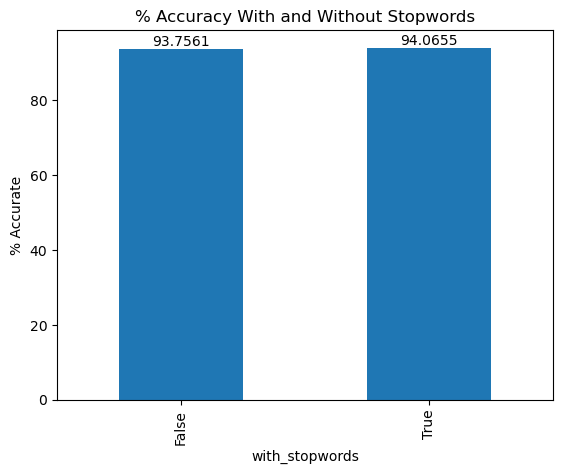

In [21]:
all_results = pd.concat([with_stopwords_results_table, without_stopwords_results_table])

accuracy_graph = all_results.groupby('with_stopwords')['accuracy'].mean().plot.bar()
accuracy_graph.bar_label(accuracy_graph.containers[0])
plt.title('% Accuracy With and Without Stopwords')
plt.ylabel('% Accurate')

plt.show()

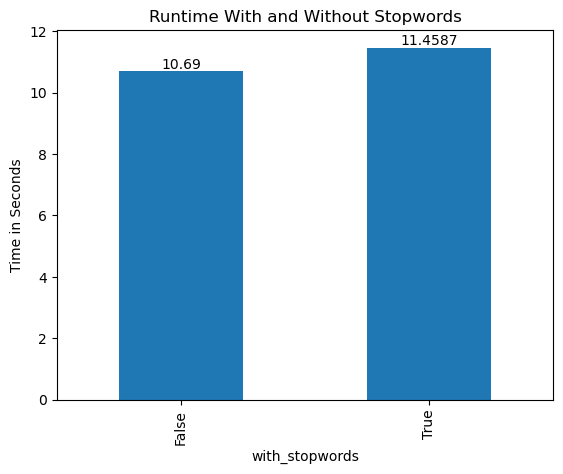

In [20]:
time_graph = all_results.groupby('with_stopwords')['time_elapsed'].mean().plot.bar()
time_graph.bar_label(time_graph.containers[0])
plt.title('Runtime With and Without Stopwords')
plt.ylabel('Time in Seconds')
plt.show()

## Step 2: Get probabilities that any one email in the training data is either spam or ham

In the labelled dataset, count the number of spam and ham emails.

$P(Spam) = \frac{Spam\,Emails}{Total\,Emails}$

$P(Ham) = \frac{Ham\,Emails}{Total\,Emails}$

## Step 3: Get the "spamicity" and "hamicity" probability of each word in the testing data email

**w** = word
<br>**vocab** = total words in dataset
<br>**spam_vocab**
<br>**wi_spam_count**

Count all unique words in the labelled dataset to get **vocab**.

Count the total number of words in labelled spam emails (ignoring uniqueness) to get **spam_vocab**.

For each word **w**, count all instances of the word in the spam emails to get **wi_spam_count**.

Calculate spamicity of each word and store the word and its spamicity in a dictionary

$P(w_{i}|Spam) = \frac{wi\_spam\_count\,+\,\alpha}{spam\_vocab\,+\,\alpha \cdot vocab}$

$\alpha$ is a coefficient that prevents a probability from being 0.


## Step 4: Calculate the "spamicity" and "hamicity" of each email

Multiply spamicities of each word together to get $\prod_{i=1}^{n}P(w_{i}|Spam)$.

Multiply that product by the probability that any email is spam.

## Step 5: Compare hamicity and spamicity scores to classify emails

## Step 6: Check accuracy of the model